In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

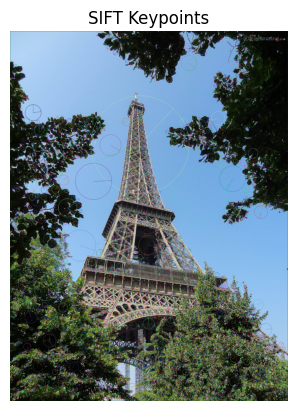

In [5]:
import cv2
import matplotlib.pyplot as plt

# Load input image
image = cv2.imread('/content/eiffel tower image 1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# SIFT Detector
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Draw keypoints
sift_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints")
plt.axis("off")
plt.show()


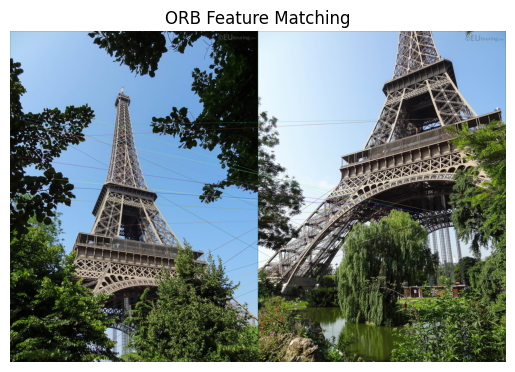

In [6]:
# Load second image for matching
image2 = cv2.imread('/content/eiffel tower image 2.jpg')
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# ORB Detector
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(gray, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

# BFMatcher with Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top 20 matches
matched_image = cv2.drawMatches(image, kp1, image2, kp2, matches[:20], None, flags=2)
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title("ORB Feature Matching")
plt.axis("off")
plt.show()


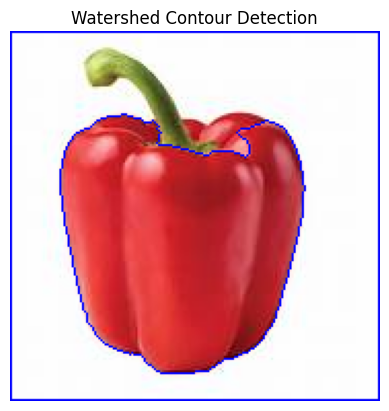

In [7]:
import numpy as np

# Read and convert image
img = cv2.imread('/content/bell pepper image red.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold to get sure background and sure foreground
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance transform and sure foreground
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  # so background is not 0, but 1
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]  # mark boundaries in red

# Display result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Watershed Contour Detection")
plt.axis("off")
plt.show()


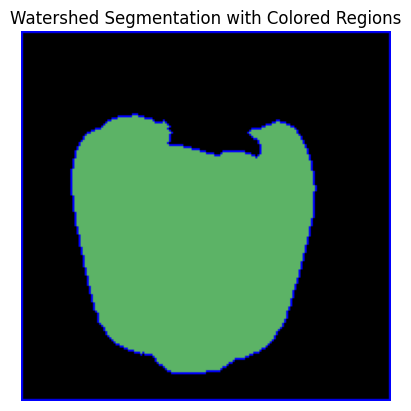

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read and convert image
img = cv2.imread('/content/bell pepper image red.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold to get sure background and sure foreground
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance transform and sure foreground
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  # Ensure background is not 0 but 1
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)

# Create an output image to visualize different regions
output = np.zeros_like(img)

# Assign random colors to each unique region label
np.random.seed(42)  # For reproducibility
unique_markers = np.unique(markers)
colors = {marker: np.random.randint(0, 255, 3).tolist() for marker in unique_markers if marker > 1}

for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        if markers[i, j] > 1:
            output[i, j] = colors[markers[i, j]]
        elif markers[i, j] == -1:
            output[i, j] = [255, 0, 0]  # Red for boundaries

# Display result
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Watershed Segmentation with Colored Regions")
plt.axis("off")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Data transforms & loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Step 2: Define training and evaluation functions
def train_model(model, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {100*correct/total:.2f}%")

def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    end_time = time.time()
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}% | Inference Time: {end_time - start_time:.2f}s")
    return acc, end_time - start_time

# Step 3: Load and prepare ResNet18
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)
resnet18 = resnet18.to(device)

# Step 4: Load and prepare ResNet34
resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)
resnet34 = resnet34.to(device)

# Step 5: Define loss and optimizers
criterion = nn.CrossEntropyLoss()
resnet18_optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)
resnet34_optimizer = torch.optim.Adam(resnet34.parameters(), lr=0.0001)

# Step 6: Train both models
print("\nTraining ResNet18...")
train_model(resnet18, criterion, resnet18_optimizer, epochs=10)


Files already downloaded and verified
Files already downloaded and verified

Training ResNet18...
Epoch 1/10 | Loss: 1.5812 | Accuracy: 61.23%
Epoch 2/10 | Loss: 0.6750 | Accuracy: 80.89%
Epoch 3/10 | Loss: 0.3648 | Accuracy: 89.71%
Epoch 4/10 | Loss: 0.1972 | Accuracy: 94.70%
Epoch 5/10 | Loss: 0.1257 | Accuracy: 96.78%
Epoch 6/10 | Loss: 0.0989 | Accuracy: 97.45%
Epoch 7/10 | Loss: 0.0796 | Accuracy: 97.95%
Epoch 8/10 | Loss: 0.0771 | Accuracy: 97.86%
Epoch 9/10 | Loss: 0.0648 | Accuracy: 98.20%
Epoch 10/10 | Loss: 0.0603 | Accuracy: 98.37%


In [ ]:

print("\nTraining ResNet34...")
train_model(resnet34, criterion, resnet34_optimizer, epochs=10)

# Step 7: Evaluate both models
print("\nEvaluating ResNet18...")
res18_acc, res18_time = evaluate_model(resnet18)

print("\nEvaluating ResNet34...")
res34_acc, res34_time = evaluate_model(resnet34)

# Step 8: Final comparison
print("\n--- Final Comparison ---")
print(f"ResNet18 -> Accuracy: {res18_acc:.2f}% | Inference Time: {res18_time:.2f}s")
print(f"ResNet34 -> Accuracy: {res34_acc:.2f}% | Inference Time: {res34_time:.2f}s")



Training ResNet34...
Epoch 1/10 | Loss: 1.3931 | Accuracy: 63.78%
Epoch 2/10 | Loss: 0.6383 | Accuracy: 81.35%
Epoch 3/10 | Loss: 0.4004 | Accuracy: 87.74%
Epoch 4/10 | Loss: 0.2772 | Accuracy: 91.52%
Epoch 5/10 | Loss: 0.2026 | Accuracy: 93.78%
Epoch 6/10 | Loss: 0.1770 | Accuracy: 94.51%
Epoch 7/10 | Loss: 0.1364 | Accuracy: 95.86%
Epoch 8/10 | Loss: 0.1248 | Accuracy: 96.16%
Epoch 9/10 | Loss: 0.1082 | Accuracy: 96.72%
Epoch 10/10 | Loss: 0.1019 | Accuracy: 96.88%

Evaluating ResNet18...
Test Accuracy: 76.05% | Inference Time: 19.76s

Evaluating ResNet34...
Test Accuracy: 78.28% | Inference Time: 25.53s

--- Final Comparison ---
ResNet18 -> Accuracy: 76.05% | Inference Time: 19.76s
ResNet34 -> Accuracy: 78.28% | Inference Time: 25.53s


In [ ]:
#task2.2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
from sklearn.metrics import classification_report
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_train))
test_size = len(mnist_train) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mnist_train, [train_size, test_size])

# Group by class
def group_by_class(dataset):
    class_dict = {}
    for img, label in dataset:
        if label not in class_dict:
            class_dict[label] = []
        class_dict[label].append(img)
    return class_dict

train_classes = group_by_class(train_dataset)
test_classes = group_by_class(test_dataset)

# Improved ConvEncoder
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3),  # 26x26
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3),  # 24x24
            nn.ReLU(),
            nn.MaxPool2d(2),       # 12x12
            nn.Conv2d(64, 128, 3), # 10x10
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),       # 5x5
            nn.Flatten(),
            nn.Linear(128 * 5 * 5, 256)
        )

    def forward(self, x):
        return self.encoder(x)

# Create episodes
def create_episode(class_dict, N=5, K=5, Q=5):
    selected_classes = random.sample(list(class_dict.keys()), N)
    support_set, query_set = [], []

    for i, cls in enumerate(selected_classes):
        samples = random.sample(class_dict[cls], K + Q)
        support_imgs = samples[:K]
        query_imgs = samples[K:]
        support_set += [(img, i) for img in support_imgs]
        query_set += [(img, i) for img in query_imgs]

    return support_set, query_set

def compute_prototypes(support_set, model):
    class_embeddings = {}
    for img, cls in support_set:
        img = img.unsqueeze(0).to(device)
        emb = model(img)
        if cls not in class_embeddings:
            class_embeddings[cls] = []
        class_embeddings[cls].append(emb)

    prototypes = {}
    for cls in class_embeddings:
        prototypes[cls] = torch.stack(class_embeddings[cls]).mean(0)

    return prototypes

def evaluate_query_set(query_set, prototypes, model):
    y_true, y_pred = [], []

    for img, label in query_set:
        img = img.unsqueeze(0).to(device)
        emb = model(img)
        distances = {cls: torch.norm(emb - proto) for cls, proto in prototypes.items()}
        pred_class = min(distances, key=distances.get)

        y_true.append(label)
        y_pred.append(pred_class)

    return y_true, y_pred

# Training loop
def train_proto_net(model, class_dict, episodes=1000, N=5, K=5, Q=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for episode in range(episodes):
        support_set, query_set = create_episode(class_dict, N, K, Q)
        prototypes = compute_prototypes(support_set, model)

        loss = 0.0
        for img, label in query_set:
            img = img.unsqueeze(0).to(device)
            emb = model(img)

            # Compute distance to all prototypes
            distances = torch.stack([torch.norm(emb - proto) for proto in prototypes.values()])
            logits = -distances  # lower distance = higher logit
            target = torch.tensor([label]).to(device)
            loss += F.cross_entropy(logits.unsqueeze(0), target)

        loss /= len(query_set)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if episode % 100 == 0:
            print(f"Episode {episode} - Loss: {loss.item():.4f}")

# Evaluation
def evaluate_proto_net(model, class_dict, N=5, K=5, Q=5):
    model.eval()
    support_set, query_set = create_episode(class_dict, N, K, Q)
    prototypes = compute_prototypes(support_set, model)
    y_true, y_pred = evaluate_query_set(query_set, prototypes, model)

    print("\nFew-shot Evaluation:")
    print(classification_report(y_true, y_pred))

# ===================== RUN ======================

model = ConvEncoder().to(device)
train_proto_net(model, train_classes, episodes=1000, N=5, K=5, Q=5, lr=1e-3)
evaluate_proto_net(model, test_classes, N=5, K=5, Q=5)


Episode 0 - Loss: 0.6858
Episode 100 - Loss: 0.0092
Episode 200 - Loss: 0.3170
Episode 300 - Loss: 0.6256
Episode 400 - Loss: 0.0596
Episode 500 - Loss: 0.5299
Episode 600 - Loss: 0.0475
Episode 700 - Loss: 0.0000
Episode 800 - Loss: 0.0001
Episode 900 - Loss: 0.0288

Few-shot Evaluation:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.83      1.00      0.91         5
           2       0.71      1.00      0.83         5
           3       1.00      0.40      0.57         5
           4       1.00      0.80      0.89         5

    accuracy                           0.84        25
   macro avg       0.88      0.84      0.82        25
weighted avg       0.88      0.84      0.82        25

